In [1]:
%run ParserLexer.ipynb
%matplotlib inline
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn-whitegrid')

In [2]:
# Tidying functions

# Remove back-to-back Rearray/Dearray pairs
def compose_maps(g, *kwargs):
#     add_dt_to_channels_g(g)
    ns = g["nodes"]
    cs = g["channels"]
    n_dict = dict([(n.name, n) for n in ns])
    rds = [ c for c in cs if ((getcn(n_dict[c.src_act]) == "Dearray" 
                        and getcn(n_dict[c.dst_act]) == "Rearray")
                       or (getcn(n_dict[c.src_act]) == "Rearray" 
                        and getcn(n_dict[c.dst_act]) == "Dearray"))]
    for rd in rds:
        src = n_dict[rd.src_act]
        dst = n_dict[rd.dst_act]
        assert(getcn(src) in ["Rearray", "Dearray"])
        assert(getcn(dst) in ["Rearray", "Dearray"])
        if src.output.rate == dst.input.rate:
            inc_c = [c for c in cs if  c.dst_port == src.input.name][0]
            out_c = [c for c in cs if c.src_port == dst.output.name][0]
            if str(inc_c.datatype) == str(out_c.datatype):
                new_c = Channel(inc_c.src_act, out_c.dst_act, inc_c.src_port, out_c.dst_port)
                new_c.add_dt(inc_c.datatype)
                cs = [c for c in cs if c not in [inc_c, out_c, rd]] + [new_c]
                ns = [n for n in ns if n not in [src, dst]]
            else:
                print(str(inc_c.datatype), str(out_c.datatype))
    g["nodes"] = ns
    g["channels"] = cs
    add_dt_to_channels_g(g)
    return g

In [3]:
# Generation functions

# Compile Recursive CSDF graph

def exploder(methods):
    return lambda g: explode(g, methods)

def explode(graph, methods):
    for method in methods:
        method(graph, exploder(methods))
#         c
    return graph


def discrete_zip(graph, explode_method):
#     add_dt_to_channels_g(graph)
    nodes = graph["nodes"]
    channels = graph["channels"]
    def_len = 10
    
    # get Zip nodes
    zipnodes = [n for n in nodes if getcn(n) == "Zip"]
    # explode Zip nodes
    for node in zipnodes:
        name = node.name
        
        old_in_channels = [c for c in channels if c.dst_act == name]
        old_out_channel = [c for c in channels if c.src_act == name]
        assert(len(old_in_channels) >= 1)
        assert(len(old_out_channel) <= 1)
        
        zippee = Zippee(node.name + "XZippee")
        zippee.add_dt(Tuple(node.datatype.subdata.subdatals))
        
        
        for din, i in zip(old_in_channels, range(len(old_in_channels))):
            da_in = [x for x in node.input if x.name == din.dst_port][0]
            da_out = Port("out", name + "XDA_out_x"+str(i), [node.datatype.length])
            da = Dearray(name + "XDA_x"+str(i), da_in, da_out)
            da.datatype = din.datatype.subdata
            din.dst_act = da.name
            nodes.append(da)
            channels.append(Channel(da.name, zippee.name, da_out.name, zippee.new_inport().name))
            
                          
        ra_out = node.output
        ra_in = Port("in", name + "XRA_in", [node.datatype.length])
        ra = Rearray(name + "XRA", ra_in, ra_out, "Zip")
        ra.datatype = node.datatype
        nodes += [ra, zippee]
        old_out_channel[0].src_act = ra.name
        channels.append(Channel(zippee.name, ra.name, zippee.output.name, ra.input.name))
        
        
    # remove Zip nodes
    nodes = [n for n in nodes if getcn(n) != "Zip"]
    
    
    graph["nodes"] = nodes
    graph["channels"] = channels
    return graph

def parallel_map(graph, explode_method, groupsize = 1):
    def_len = 10
    nodes = graph["nodes"]
    channels = graph["channels"]
    
    # get Map nodes
    mapnodes = [n for n in nodes if getcn(n) == ("Map")]
    # explode Map nodes
    for node in mapnodes:
        name = node.name
        # get channels
        old_in_channel = [c for c in channels if c.dst_act == name]
        old_out_channel = [c for c in channels if c.src_act == name]
        inc_datatype = old_in_channel[0].datatype
        
        # make new nodes
        da_in = node.input
        da_out = Port("out", name + "XDA_out", [node.rep])
        da = Dearray(name + "XDA", da_in, da_out)
        da.datatype = inc_datatype.subdata
        
        ra_in = Port("in", name + "XRA_in", [node.rep])
        ra_out = node.output
        ra = Rearray(name + "XRA", ra_in, ra_out, "Map")
        ra.datatype = node.datatype
        
        if len(old_in_channel) == 1:
            old_in_channel[0].dst_act = da.name
        if len(old_out_channel) == 1:
            old_out_channel[0].src_act = ra.name
        
        
        # make Splitter and link to dearray
        total_vals =  inc_datatype.length
        routes = int(total_vals / groupsize)
        assert( total_vals % groupsize == 0)
        
        spl = Splitter(name+"XSpl", routes, groupsize, 0)
        spl.add_dt(inc_datatype.subdata)
        channels += [Channel(da.name, spl.name, da_out.name, spl.input.name)]
        
        # make Joiner and link to Rearray        
        jnr = Joiner(name+"XJnr", routes, groupsize)
        jnr.add_dt(node.datatype.subdata)
        channels += [Channel(jnr.name, ra.name, jnr.output.name, ra_in.name)]
        
        # add nodes
        nodes += [da, ra, jnr, spl]
        subgraph = explode_method(node.subfunc)
        externals = [c.src_act for c in subgraph['channels'] if c.src_act not in [n.name for n in subgraph['nodes']]]
        externals = [n for n in nodes if n.name in externals]
        count = 0
        for i in range(routes):
            count += 1
            print("Copying subgraph", i)
            sg = deepcopy(subgraph, count)
            print('Copied subgraph', i)
            
            for n in externals:
#                 print(n.name)
                for cc in [c for c in sg['channels'] if c.src_act == n.name]:
                    cc.name = cc.name + "_x" + str(count)
                    po = n.new_outport()
                    cc.src_port = po.name
            
            
            so = sg["output"].name
            si = sg["inputs"][0].name
            
            channels += [Channel(spl.name, 
                                 get_node_by_port(sg["nodes"], si).name, 
                                 spl.output[i].name, si), 
                         Channel(get_node_by_port(sg["nodes"], so).name, 
                                 jnr.name, so, jnr.input[i].name)]
            
            nodes += sg["nodes"]
            channels += sg["channels"]
        
    # remove Map nodes
    nodes = [n for n in nodes if not getcn(n)=="Map"]
    
    
    graph["nodes"] = nodes
    graph["channels"] = channels
    return graph
            


def recursive_map(graph, explode_method):
    nodes = graph["nodes"]
    channels = graph["channels"]
    def_len = 10
    
    # get Map nodes
    mapnodes = [n for n in nodes if getcn(n) == "Map"]
    # explode Map nodes
    for node in mapnodes:
#         print(node.name, getcn(node), node.datatype)
        name = node.name
        
        old_in_channel = [c for c in channels if c.dst_act == name]
        old_out_channel = [c for c in channels if c.src_act == name]
        assert(len(old_in_channel) == 1)
        assert(len(old_out_channel) <= 1)
        da_in = node.input
        da_out = Port("out", name + "XDA_out", [node.rep])
        da = Dearray(name + "XDA", da_in, da_out)
        da.datatype = old_in_channel[0].datatype.subdata
        ra_out = node.output
        ra_in = Port("in", name + "XRA_in", [node.rep])
        ra = Rearray(name + "XRA", ra_in, ra_out, "Map")
        ra.datatype = node.datatype
        
        subgraph = explode_method(node.subfunc)
        nodes += subgraph["nodes"]
        nodes += [da, ra]
        
        if len(old_in_channel) == 1:
            old_in_channel[0].dst_act = da.name
        if len(old_out_channel) == 1:
            old_out_channel[0].src_act = ra.name
        channels += subgraph["channels"]
        so = subgraph["output"].name
        si = subgraph["inputs"][0].name
        channels += [Channel(da.name, 
                             get_node_by_port(subgraph["nodes"], si).name, 
                             da_out.name, si), 
                     Channel(get_node_by_port(subgraph["nodes"], so).name, 
                             ra.name, so, ra_in.name)]
    # remove Map nodes
    nodes = [n for n in nodes if getcn(n) != "Map"]
    
    
    graph["nodes"] = nodes
    graph["channels"] = channels
    return graph


def recursive_map(graph, explode_method):
    nodes = graph["nodes"]
    channels = graph["channels"]
    def_len = 10
    
    # get Map nodes
    mapnodes = [n for n in nodes if getcn(n) == "Map"]
    # explode Map nodes
    for node in mapnodes:
#         print(node.name, getcn(node), node.datatype)
        name = node.name
        
        old_in_channel = [c for c in channels if c.dst_act == name]
        old_out_channel = [c for c in channels if c.src_act == name]
        assert(len(old_in_channel) == 1)
        assert(len(old_out_channel) <= 1)
        da_in = node.input
        da_out = Port("out", name + "XDA_out", [node.rep])
        da = Dearray(name + "XDA", da_in, da_out)
        da.datatype = old_in_channel[0].datatype.subdata
        ra_out = node.output
        ra_in = Port("in", name + "XRA_in", [node.rep])
        ra = Rearray(name + "XRA", ra_in, ra_out, "Map")
        ra.datatype = node.datatype
        
        subgraph = explode_method(node.subfunc)
        nodes += subgraph["nodes"]
        nodes += [da, ra]
        
        if len(old_in_channel) == 1:
            old_in_channel[0].dst_act = da.name
        if len(old_out_channel) == 1:
            old_out_channel[0].src_act = ra.name
        channels += subgraph["channels"]
        so = subgraph["output"].name
        si = subgraph["inputs"][0].name
        channels += [Channel(da.name, 
                             get_node_by_port(subgraph["nodes"], si).name, 
                             da_out.name, si), 
                     Channel(get_node_by_port(subgraph["nodes"], so).name, 
                             ra.name, so, ra_in.name)]
    # remove Map nodes
    nodes = [n for n in nodes if getcn(n) != "Map"]
    
    
    graph["nodes"] = nodes
    graph["channels"] = channels
    return graph

def recursive_reduce(graph, explode_method):
    def_len = 10
    nodes = graph["nodes"]
    channels = graph["channels"]
    
    # get Reduce nodes
    reducenodes = [n for n in nodes if getcn(n).startswith("Reduce")]
    # explode Reduce nodes
    for node in reducenodes:
        name = node.name
        # get channels
        old_in_channel = [c for c in channels if c.dst_act == name]
        old_out_channel = [c for c in channels if c.src_act == name]
        
        # make new nodes
        da_in = node.input
        da_out = Port("out", name + "XDA_out", [node.rep])
        da = Dearray(name + "XDA", da_in, da_out)
        da.datatype = old_in_channel[0].datatype.subdata
        
        ra_in = Port("in", name + "XRA_in", [1])
        ra_out = node.output
        ra = Rearray(name + "XRA", ra_in, ra_out, "Reduce")
        ra.datatype = node.datatype
        
        if len(old_in_channel) == 1:
            old_in_channel[0].dst_act = da.name
        if len(old_out_channel) == 1:
            old_out_channel[0].src_act = ra.name
        
        # make param for recursion
        para = Param(name + "XPARA", "recursion")
        para.datatype = node.datatype.subdata
        para.input.rate = [1] * node.rep
        para_out_0 = para.new_outport([1] * node.rep)
        para_out_1 = para.new_outport([0] * (node.rep - 1) + [1])
        
        # add nodes
        subgraph = explode_method(node.subfunc)
        nodes += subgraph["nodes"]
        nodes += [da, ra, para]
        
        # add channels
        si = subgraph["inputs"]
        so = subgraph["output"].name
        channels += [Channel(para.name, get_node_by_port(subgraph["nodes"], si[1].name).name, 
                             para_out_0.name, si[1].name, 1),
                     Channel(da.name, get_node_by_port(subgraph["nodes"], si[0].name).name, 
                             da_out.name, si[0].name),
                     Channel(get_node_by_port(subgraph["nodes"], so).name, para.name,
                             so, para.input.name),
                     Channel(para.name, ra.name,
                             para_out_1.name, ra_in.name)]
        channels += subgraph["channels"]
        
    # remove Reduce nodes
    nodes = [n for n in nodes if not getcn(n).startswith("Reduce")]
    
    graph["nodes"] = nodes
    graph["channels"] = channels
    return graph
            


In [4]:
def deepcopy(g, i):
    i = str(i)
    newg = copy.deepcopy(g)
    nodes = newg['nodes']
    nodenames = [n.name for n in nodes]
    for channel in newg['channels']:
        if channel.src_act in nodenames and channel.dst_act in nodenames:
            channel.name = channel.name + "_x" + i
        if channel.src_act in nodenames:
            channel.src_act = channel.src_act + "_x" + i
            channel.src_port = channel.src_port + "_x" + i
        if channel.dst_act in nodenames:
            channel.dst_act = channel.dst_act + "_x" + i
            channel.dst_port = channel.dst_port + "_x" + i
    for node in nodes:
        node.name = node.name + "_x" + i
        for port in getports(node):
            port.name = port.name + "_x" + i
    return newg

In [5]:
def parallel_reducer(graph, explode_method, groupsize = 1):
    def_len = 10
    nodes = graph["nodes"]
    channels = graph["channels"]
    
    # get Reduce nodes
    reducenodes = [n for n in nodes if getcn(n) == ("Reduce")]
    # explode Reduce nodes
    for node in reducenodes:
        name = node.name
        # get channels
        old_in_channel = [c for c in channels if c.dst_act == name]
        old_out_channel = [c for c in channels if c.src_act == name]
        inc_datatype = old_in_channel[0].datatype
        
        # make new nodes
        da_in = node.input
        da_out = Port("out", name + "XDA_out", [node.rep])
        da = Dearray(name + "XDA", da_in, da_out)
        da.datatype = inc_datatype.subdata
        
        ra_in = Port("in", name + "XRA_in", [1])
        ra_out = node.output
        ra = Rearray(name + "XRA", ra_in, ra_out, "Reduce")
        ra.datatype = node.datatype
        
        if len(old_in_channel) == 1:
            old_in_channel[0].dst_act = da.name
        if len(old_out_channel) == 1:
            old_out_channel[0].src_act = ra.name
        
        # make initial value
        ival = Value(name + "XInitVal", node.initval, inc_datatype.subdata)
        ival.add_dt(inc_datatype.subdata)
        
#         print(inc_datatype)
        
        # make Splitter and link to dearray
        total_vals =  inc_datatype.length
        routes = int(total_vals / groupsize)
        remaining = total_vals % groupsize
        
        spl = Splitter(name+"XSpl", routes, groupsize, remaining)
        spl.add_dt(inc_datatype.subdata)
        channels += [Channel(da.name, spl.name, da_out.name, spl.input.name)]
        
        # add nodes
        nodes += [da, ra, ival, spl]
        subgraph = explode_method(node.subfunc)
        datavals = [(spl.name, p.name) for p in spl.output] + [(ival.name, ival.output.name)]
        count = 0
        while len(datavals) > 1:
            sg = deepcopy(subgraph, count)
            count += 1
            nodes += sg["nodes"]
            channels += sg["channels"]
            # add channels
            in1 = datavals.pop(0)
            in2 = datavals.pop(0)
            si = sg["inputs"]
            
            channels += [Channel(in1[0], get_node_by_port(sg["nodes"], si[0].name).name, 
                                 in1[1], si[0].name),
                         Channel(in2[0], get_node_by_port(sg["nodes"], si[1].name).name, 
                                 in2[1], si[1].name)]
            so = sg["output"].name
            datavals.append((get_node_by_port(sg["nodes"], so).name, so))
        in1 = datavals.pop()
        channels.append(Channel(in1[0], ra.name, 
                                 in1[1], ra_in.name))
        
    # remove Reduce nodes
    nodes = [n for n in nodes if not getcn(n)=="Reduce"]
    
    
    graph["nodes"] = nodes
    graph["channels"] = channels
    return graph
            


parallel_reduce = lambda a, b: parallel_reducer(a, b, 1)

In [6]:

recursive_explode = exploder([recursive_map, recursive_reduce])
parallel_explode = exploder([parallel_reduce, recursive_map, recursive_reduce])

In [7]:
# Put together
def fullfettle(filename, method, sizevar_file = None):
    p = parse_file(filename, sizevar_file)
    g = p['graph']
    method(g)
    add_dt_to_channels(p)
    check_correct(g)
    return p

def smush_rede(p):
    compose_maps(p['graph'])
    add_dt_to_channels(p)
    return p


# Put together
def get_rec_csdf(filename, sizevar_file = None):
    return fullfettle(filename, recursive_explode, sizevar_file)
def get_parallel_csdf(filename, sizevar_file = None):
    return fullfettle(filename, parallel_explode, sizevar_file)

def write_csdf_from_hl(from_file, to_file):
    write_csdf(get_rec_csdf(from_file)["graph"], to_file)

def try_do(filename, methods, sizevar_file = None):
    try:
        p = parse_file(filename, sizevar_file)
        g = p['graph']
        exploder(methods)(g)
        add_dt_to_channels(p)
        check_correct(g)
        return(p)
    except Exception as e:
        print("\nCouldn't get CSDF for " + filename)
        raise(e)
        return False

In [8]:
recmethods = [discrete_zip, parallel_map, recursive_reduce]
p = try_do("highLevel/mydotsmol", recmethods, [3] * 10)
k = p['graph']

In [9]:
printgraph_simple(k)
add_dt_to_channels(p)

n1: Param
n2: Param
n3: Param
n4: Param
n10XDA_x0: Dearray
n10XDA_x1: Dearray
n10XRA: Rearray
n10XZippee: Zippee
n9XDA: Dearray
n9XRA: Rearray
n9XJnr: Joiner
n9XSpl: Splitter
n5_x1: Param
n7_x1: Get
n8_x1: Get
n6_x1: Mather
n5_x2: Param
n7_x2: Get
n8_x2: Get
n6_x2: Mather
n5_x3: Param
n7_x3: Get
n8_x3: Get
n6_x3: Mather
n11XDA: Dearray
n11XRA: Rearray
n11XPARA: Param
[('n1', 'n11XDA', 'Array (3, Array (3, Float))')]
[('n11XPARA', 'n4', 'Array (3, Float)')]
[('n11XDA', 'n3', 'Array (3, Float)')]
[('n9XRA', 'n11XPARA', 'Array (3, Float)')]
[('n11XPARA', 'n11XRA', 'Array (3, Float)')]
[('n3', 'n10XDA_x0', 'Array (3, Float)')]
[('n4', 'n10XDA_x1', 'Array (3, Float)')]
[('n10XRA', 'n9XDA', 'Array (3, Tuple (Float, Float))')]
[('n10XDA_x0', 'n10XZippee', 'Float')]
[('n10XDA_x1', 'n10XZippee', 'Float')]
[('n10XZippee', 'n10XRA', 'Tuple (Float, Float)')]
[('n9XDA', 'n9XSpl', 'Tuple (Float, Float)')]
[('n9XJnr', 'n9XRA', 'Float')]
[('n9XSpl', 'n5_x1', 'Tuple (Float, Float)')]
[('n6_x1', 'n9XJnr

{'sizevars': ['K', 'N'],
 'inputs': [('R', 'ArrayType(ArrayType(Float, K), N)'),
  ('I', 'ArrayType(Float, K)')],
 'code': '\n  ArrayType(ArrayType(Float, K), N),\n  ArrayType(Float, K),\n  (R, I) =>\n  \tR :>> Reduce(\\((A, B) =>\n  \t  \t    Map(fun(x => \n  \t  \t        \t\tmult(Get(x, 0), Get(x, 1))))\n  \t  \t    $ Zip(A, B)), I)\n',
 'graph': {'nodes': [<__main__.Param at 0x106e5d750>,
  'channels': [<__main__.Channel at 0x106e81ed0>,
  'inputs': [<__main__.Port at 0x106e5d310>, <__main__.Port at 0x106e5d690>],
  'output': <__main__.Port at 0x106e81e10>}}

In [10]:
[c.src_act for c in k['channels']]

['n1',
 'n11XPARA',
 'n11XDA',
 'n9XRA',
 'n11XPARA',
 'n3',
 'n4',
 'n10XRA',
 'n10XDA_x0',
 'n10XDA_x1',
 'n10XZippee',
 'n9XDA',
 'n9XJnr',
 'n9XSpl',
 'n6_x1',
 'n5_x1',
 'n7_x1',
 'n5_x1',
 'n8_x1',
 'n9XSpl',
 'n6_x2',
 'n5_x2',
 'n7_x2',
 'n5_x2',
 'n8_x2',
 'n9XSpl',
 'n6_x3',
 'n5_x3',
 'n7_x3',
 'n5_x3',
 'n8_x3']

In [42]:
import timeit


# parreducemethods = [parallel_reduce, recursive_map, recursive_reduce]
# parmethods = [parallel_reduce, parallel_map, recursive_reduce]
# naivemethods = [recursive_map, recursive_reduce]
# parmapmethods = [parallel_map, recursive_reduce]
# ls = range(1, 502, 50)
# naive_ct = []
# par_ct = []
# for i in ls:
#     print(i)
#     x = %timeit -n100 -q -o try_do("highLevel/asum", naivemethods, [i])
#     naive_ct.append(sum(x.all_runs)/x.loops/x.repeat)
#     print(x.loops, x.repeat)
#     x = %timeit -n100 -q -o try_do("highLevel/asum", parmapmethods, [i])
#     par_ct.append(sum(x.all_runs)/x.loops/x.repeat)
#     print(x.loops, x.repeat)



1
100 7
100 7
51
100 7
100 7
101
100 7
100 7
151
100 7
100 7
201
100 7
100 7
251
100 7
100 7
301
100 7
100 7
351
100 7
100 7
401
100 7
100 7
451
100 7
100 7
501
100 7
100 7


<TimeitResult : 141 ms ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)>

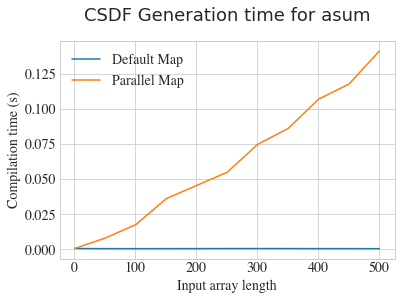

In [53]:

ff = {'family':'serif',
      'sans-serif':['Adobe Arabic'],
      'serif':['Times'],
      'size': 14
     }


plt.rc('font', **ff)

# fig1, ax1 = plt.subplots(figsize=(5,5))
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',  startangle=90)
# ax1.axis('equal') 

# plt.title("CSDF Generation Success Rate", pad=20, 
#           fontdict={'family':'sans-serif', 'size':18})
# plt.savefig("Graphs/GenerationSuccessRatePie.png")

plt.plot(ls, naive_ct, label='Default Map')
plt.plot(ls, par_ct, label='Parallel Map')
# plt.title('CSDF Generation time for asum')
plt.ylabel('Compilation time (s)')
plt.xlabel('Input array length')
plt.title("CSDF Generation time for asum", pad=20, 
          fontdict={'family':'sans-serif', 'size':18})
plt.legend()
plt.savefig("Graphs/AsumGenerationTime.png")
plt.show()


In [44]:
par_ct

[0.0007193738171425983,
 0.008118547714285895,
 0.01769014657857156,
 0.03611940392142872,
 0.045488045904285825,
 0.05487110860142853,
 0.07468838649571466,
 0.08596628359142836,
 0.10680891441714364,
 0.11755385689142875,
 0.14108672793428534]

In [39]:
def tst5(k):
    return k**k
x = %timeit  -q -o tst5(9)
sum(x.all_runs)/x.loops/x.repeat

In [40]:
print(sum(x.all_runs)/x.loops/x.repeat,x.best)
x.all_runs, x.loops, x.repeat

3.550718842857188e-07 3.137222230000134e-07


([0.3418676469999582,
  0.3617993300000535,
  0.4372193699999798,
  0.3935758599999417,
  0.3137222230000134,
  0.316869587000042,
  0.3204491730000427],
 1000000,
 7)

In [ ]:
# def test():
#     write_csdf_from_hl(add_cwd("highLevel/mmNN"), add_cwd("csdf_xmls/mmNN"))
    
def testr():
    return get_rec_csdf(add_cwd("highLevel/mmNN"))
def testp():
    return get_parallel_csdf(add_cwd("highLevel/mmNN"))

In [ ]:
k = get_rec_csdf(add_cwd("highLevel/mydot"), [10,10,10,10,10])
zz = k['graph']['nodes'][10]


In [ ]:
print(zz.datatype)

In [ ]:
with open('sfile.txt', 'w') as f:
    f.write('\n'.join(['10']*5))

In [ ]:
gr = testr()['graph']

In [ ]:
gr